# Proposal 3

$$
\mathcal{L} = \mathcal{L}_c + \lambda_e \cdot || \bm{p^*_A} \odot \bm{(\theta - \theta^*_A) }||_1 + \lambda_f \cdot || \bm{(1 - p)} \odot \bm{\theta} ||_1
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
import pandas as pd
import plotly.express as px
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import MWUNV1
from base_code.plugins import WeightStoragePlugin

# Constants

In [42]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/proposal_3.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [43]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [44]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "lambda_e": [0.001, 0.1, 1.0, 2.0, 10.0],
    "lambda_f": [0.001, 0.5, 1.0, 10.0, 100.0],
    "eps": [1e-8, 1e-6, 1e-4, 1e-2],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[MWUNV1] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = MWUNV1(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning:

No loggers specified, metrics will not be logged



Training model 1/100
Training model 2/100
Training model 3/100
Training model 4/100
Training model 5/100
Training model 6/100
Training model 7/100
Training model 8/100
Training model 9/100
Training model 10/100
Training model 11/100
Training model 12/100
Training model 13/100
Training model 14/100
Training model 15/100
Training model 16/100
Training model 17/100
Training model 18/100
Training model 19/100
Training model 20/100
Training model 21/100
Training model 22/100
Training model 23/100
Training model 24/100
Training model 25/100
Training model 26/100
Training model 27/100
Training model 28/100
Training model 29/100
Training model 30/100
Training model 31/100
Training model 32/100
Training model 33/100
Training model 34/100
Training model 35/100
Training model 36/100
Training model 37/100
Training model 38/100
Training model 39/100
Training model 40/100
Training model 41/100
Training model 42/100
Training model 43/100
Training model 44/100
Training model 45/100
Training model 46/1

In [45]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [46]:
best_hyperparameters

{'lambda_e': 10.0, 'lambda_f': 10.0, 'eps': 0.0001}

## Evaluation metrics definition

In [47]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning:

Your system has no GPU!

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning:

Your system has no GPU!



## Plugin defitinitions

In [48]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [49]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = MWUNV1(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

-- >> Start of training phase << --
823it [00:17, 48.36it/s]                         
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 127.7000
	Loss_MB/train_phase/train_stream/Task000 = 2.6581
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.8121
100%|██████████| 469/469 [00:05<00:00, 88.23it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 122.3000
	Loss_MB/train_phase/train_stream/Task000 = 2.2429
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 5.3158
100%|██████████| 469/469 [00:04<00:00, 94.69it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 44.1000
	Loss_MB/train_phase/train_stream/Task000 = 1.9407
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.9516
100%|██████████| 469/469 [00:05<00:00, 88.36it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_strea

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.2055
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x166c7bf10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2124.5098
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 103.6016
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x177795850>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2124.4258
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.2493
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x288282eb0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2812.1836
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.1634
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x288647be0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2812.1836
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.6739
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2887b33d0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2812.2197
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814],
        [0.6807, 0.7697, 0.7794, 0.7952, 0.8215, 0.0901, 0.1284, 0.2029, 0.1768,
         0.1869],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 100.3287
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x288924e20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3500.0156
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814],
        [0.6807, 0.7697, 0.7794, 0.7952, 0.8215, 0.0901, 0.1284, 0.2029, 0.1768,
         0.1869],
        [0.6254, 0.7565, 0.7520, 0.7941, 0.8168, 0.8320, 0.1547, 0.2420, 0.1625,
         0.1536],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 102.8065
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14f629040>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3500.0205
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814],
        [0.6807, 0.7697, 0.7794, 0.7952, 0.8215, 0.0901, 0.1284, 0.2029, 0.1768,
         0.1869],
        [0.6254, 0.7565, 0.7520, 0.7941, 0.8168, 0.8320, 0.1547, 0.2420, 0.1625,
         0.1536],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5178
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14eb537c0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3500.0205
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814],
        [0.6807, 0.7697, 0.7794, 0.7952, 0.8215, 0.0901, 0.1284, 0.2029, 0.1768,
         0.1869],
        [0.6254, 0.7565, 0.7520, 0.7941, 0.8168, 0.8320, 0.1547, 0.2420, 0.1625,
         0.1536],
    

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.7157
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14fc60b20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4187.8213
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814],
        [0.6807, 0.7697, 0.7794, 0.7952, 0.8215, 0.0901, 0.1284, 0.2029, 0.1768,
         0.1869],
        [0.6254, 0.7565, 0.7520, 0.7941, 0.8168, 0.8320, 0.1547, 0.2420, 0.1625,
         0.1536],
    

100%|██████████| 10/10 [05:57<00:00, 35.79s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 102.8672
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14eab4040>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4187.8320
	EvalStream/Acc_Matrix = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7931, 0.1619, 0.1966, 0.1399, 0.1218, 0.1005, 0.1997, 0.1762, 0.1893,
         0.2362, 0.0000],
        [0.7780, 0.8031, 0.2118, 0.1645, 0.1440, 0.1059, 0.2265, 0.1638, 0.1814,
         0.2492, 0.0000],
        [0.7411, 0.7752, 0.8068, 0.1274, 0.1154, 0.1045, 0.1662, 0.1926, 0.1517,
         0.2085, 0.0000],
        [0.6768, 0.7746, 0.7905, 0.8202, 0.1099, 0.0842, 0.1626, 0.2323, 0.1223,
         0.1814, 0.0000],
        [0.6807, 0.7697, 0.7794, 0.7952, 0.8215, 0.0901, 0.1284, 0.2029, 0.1768,
         0.1869, 0.0000],
        [0.6254, 0.7565, 0.7520, 0.7941, 0.8168, 0.8320

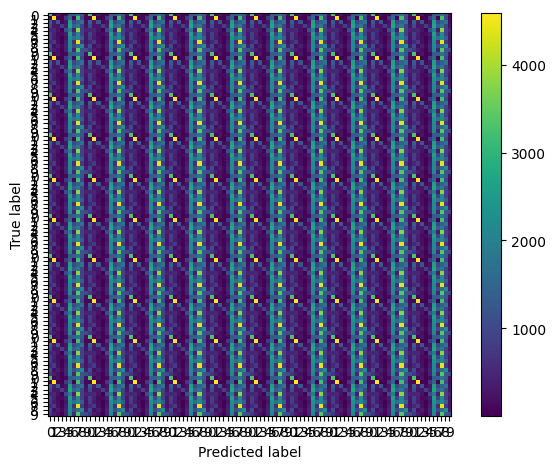

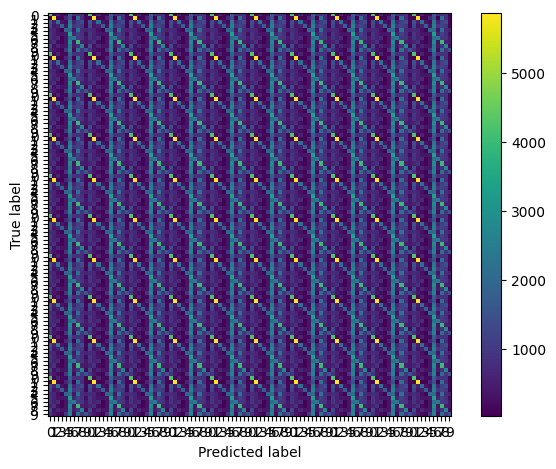

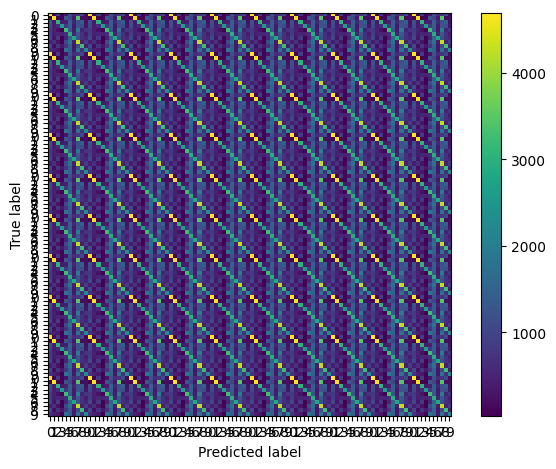

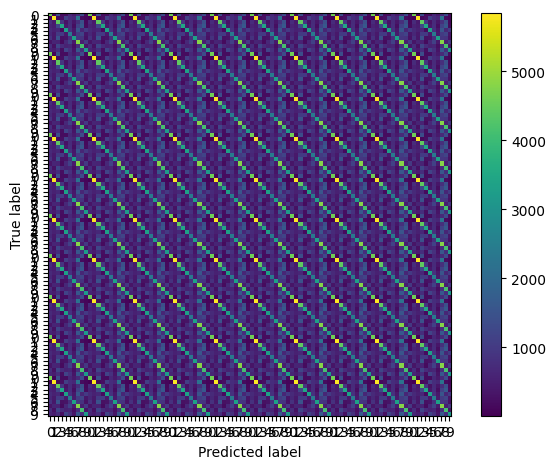

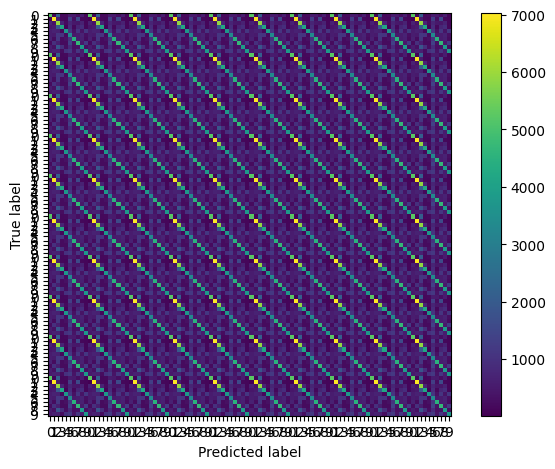

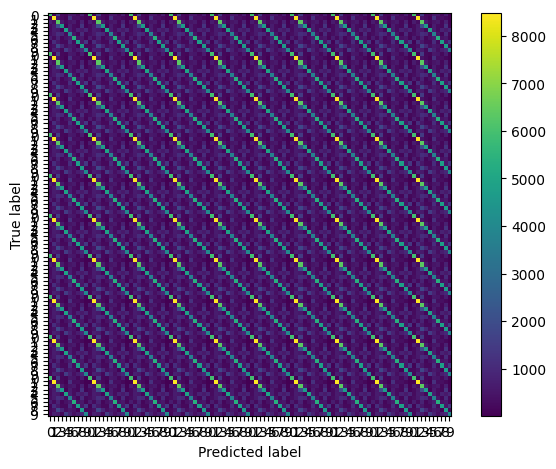

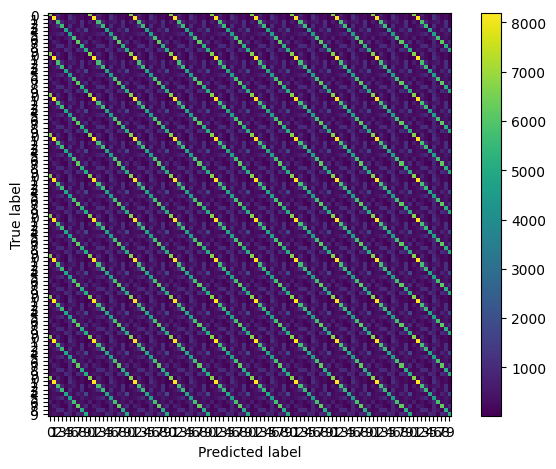

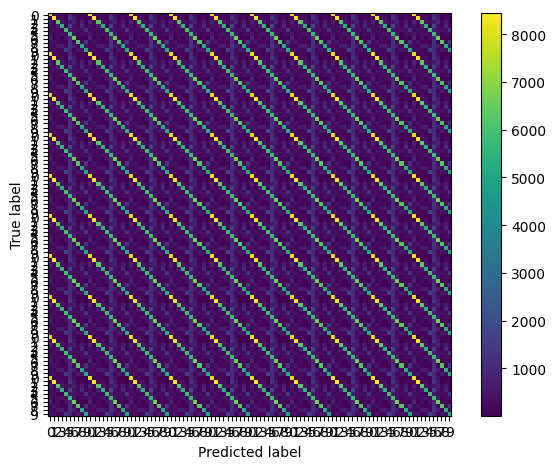

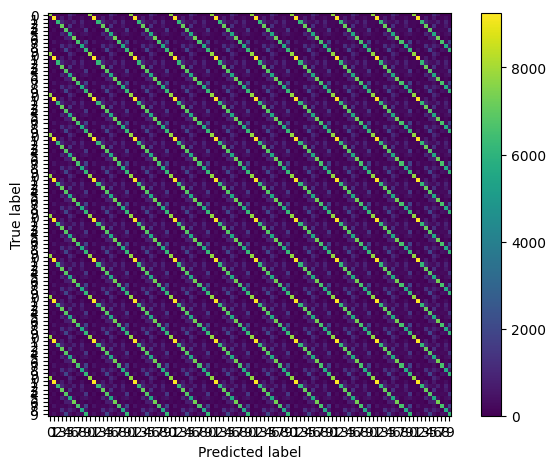

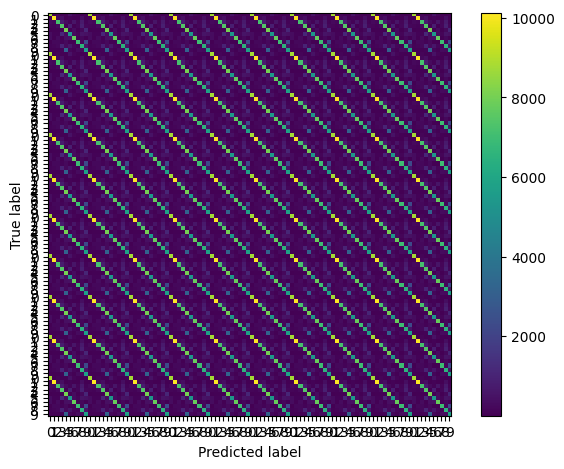

In [51]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [52]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [53]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [54]:
all_loss_components = strategy.get_store_loss()

In [55]:
weights = model_plugins[0].weights

# Store metrics

In [56]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))